# Variant Calling Report v1.1
## Input Parameters

In [1]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
from configparser import ConfigParser

pd.options.display.float_format = '{:,.2%}'.format

configFile='var_report.config'
parser = ConfigParser()
parser.read(configFile)

prmNames=['run_id',
          'h5_concordance_file', 'h5_model_file'
         ]

prm={}
for name in prmNames:
    prm[name]=parser.get('VarReport', name)

sources = {'Default':(prm['h5_concordance_file'],"concordance"),
           'Trained':(prm['h5_model_file'],"scored_concordance")
          }

data = {}
for s in sources:
    data[s]={}
    d=pd.read_hdf(sources[s][0], key=sources[s][1], mode='r')
    d=d[(d['close_to_hmer_run']==False) & (d['inside_hmer_run']==False)]
    data[s]=d

args=pd.read_hdf(sources['Default'][0], 'input_args', mode='r')
prm['truth_sample_name']=args['truth_sample_name'][0]
prmNames.append('truth_sample_name')

pd.DataFrame.from_dict(prm, orient='index',columns=['value']).reindex(prmNames)

,value
run_id,170201_BC23
h5_concordance_file,vcf_compare.BC23.h5
h5_model_file,vcf_compare.BC23.model.h5
truth_sample_name,HG002


In [2]:
def filterByCategory(data,cat):
    if cat=='SNP':
        return data[data['indel']==False]
    elif cat=='non-hmer Indel':
        return data[(data['indel']==True) & (data['hmer_indel_length']==0) & (data['indel_length']>0)]
    elif cat=='non-hmer Indel w/o LCR':
        return data[(data['indel']==True) & (data['hmer_indel_length']==0) & (data['indel_length']>0) & 
                    (~data['LCR-hs38'])]
    elif cat=='hmer Indel <=4':
        return data[(data['indel']==True) & (data['hmer_indel_length']>0) & (data['hmer_indel_length']<=4)]
    elif cat=='hmer Indel >4,<=8':
        return data[(data['indel']==True) & (data['hmer_indel_length']>4) & (data['hmer_indel_length']<=8)]
    elif cat=='hmer Indel >8,<=12':
        return data[(data['indel']==True) & (data['hmer_indel_length']>8) & (data['hmer_indel_length']<=12)]
    for i in range (1,10):
        if cat=='hmer Indel {0:d}'.format(i):
            return data[(data['indel']==True) & (data['hmer_indel_length']==i)]
    return None


In [3]:
def calcPerformance(data, gt=False):
    classify='classify_gt' if gt else 'classify'
    
    d=data.copy()
    d['tree_score'] = np.where(d[classify]=='fn',-1,d['tree_score'])
    d=d[[classify,'tree_score']].sort_values(by=['tree_score'])
    d['label'] = np.where(d[classify]=='fp',0,1)

    num=len(d)
    numPos=sum(d['label'])
    numNeg=num-numPos
    if num<10:
        return (pd.DataFrame(),None)
    
    d['fn']=np.cumsum(d['label'])
    d['tp']=numPos-(d['fn'])
    d['fp']=numNeg-np.cumsum(1-d['label'])

    d['recall']=d['tp']/(d['tp']+d['fn'])
    d['precision']=d['tp']/(d['tp']+d['fp'])

    d['dist']=((1-d['recall'])**2+(1-d['precision'])**2)**(0.5)

    d['mask']=((d['tp']+d['fn'])>=20) & ((d['tp']+d['fp'])>=20) & (d['tree_score']>=0)
    minDist=min(d[d['mask']]['dist'])
    d['opt']=(d['dist']==minDist)

    return (d[['recall','precision']][d['mask']],
            d[['recall','precision']][d['opt']],
            numPos,numNeg)



In [4]:
def plotPerformance(perfCurve,optRes,categories,ext=None):
    n=len(categories)
    fig, ax = plt.subplots(1,n,figsize=(4*n,4))
    col=['r','b','g','m','k']

    for i,cat in enumerate(categories):
        for j,s in enumerate(sources):
            perf=perfCurve[s][cat]
            opt=optRes[s][cat]
            if not perf.empty:
                ax[i].plot(perf.recall,perf.precision,'-',label=s,color=col[j])    
                ax[i].plot(opt.recall,opt.precision,'o',color=col[j])
            title=cat if ext==None else '{0} ({1})'.format(cat,ext)
            ax[i].set_title(title)
            ax[i].set_xlabel("Recall")
            ax[i].set_xlim([0.4,1])
            ax[i].set_ylim([0.4,1])
            ax[i].grid(True)

    ax[0].set_ylabel("Precision")
    ax[0].legend(loc='lower left')
    
    
def getPerformance(data,categories,gt=False):
    optTab={}
    optRes={}
    perfCurve={}
    for s in sources:
        optTab[s]=pd.DataFrame()
        optRes[s]={}
        perfCurve[s]={}

        for i,cat in enumerate(categories):
            d=filterByCategory(data[s],cat)
            perf,opt,pos,neg=calcPerformance(d,gt)
            perfCurve[s][cat]=perf
            optRes[s][cat]=opt
            
            row=pd.DataFrame({'pos':pos,
                              'neg':neg,
                              'max Recall':np.nan if perf.empty else max(perf.recall),
                              'opt Recall':np.nan if perf.empty else opt.recall[0],
                              'opt Precision':np.nan if perf.empty else opt.precision[0]
                             },index=[cat])
            optTab[s]=pd.concat([optTab[s],row])
            
    return optTab,optRes,perfCurve


## Performance: all Data

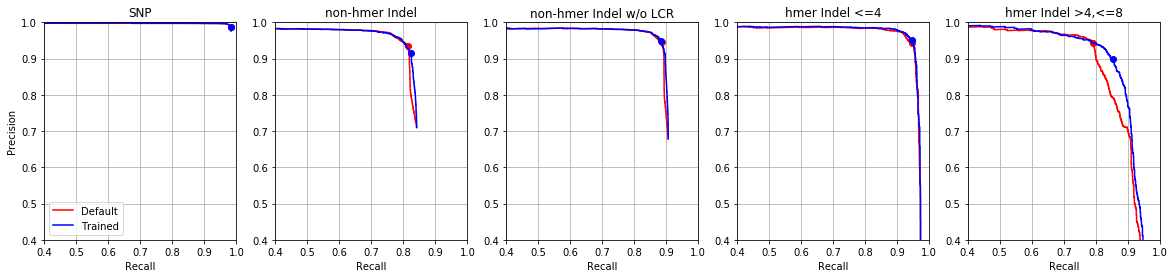

In [5]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(data,categories)
plotPerformance(perfCurve,optRes,categories)

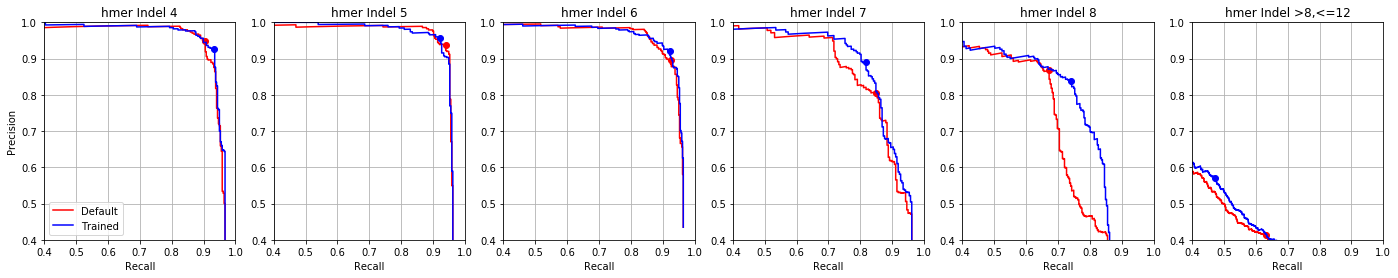

In [6]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=12']
optTab2,optRes,perfCurve=getPerformance(data,categories)
plotPerformance(perfCurve,optRes,categories)

In [7]:
pd.options.display.float_format = '{:,.2%}'.format

optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])

Default                                             \
                           pos    neg max Recall opt Recall opt Precision   
SNP                     130399   3063     98.34%     98.13%        98.83%   
non-hmer Indel            8225   2830     84.18%     81.45%        93.42%   
non-hmer Indel w/o LCR    5872   2521     90.63%     88.64%        94.45%   
hmer Indel <=4            2037  23073     97.50%     94.75%        94.38%   
hmer Indel >4,<=8         1309   3387     95.42%     79.22%        94.27%   
hmer Indel 4               339   1557     96.76%     90.56%        94.75%   
hmer Indel 5               315    698     96.19%     93.97%        93.67%   
hmer Indel 6               425    534     96.47%     92.47%        89.73%   
hmer Indel 7               258    382     96.12%     84.88%        80.51%   
hmer Indel 8               311   1773     92.60%     67.20%        86.72%   
hmer Indel >8,<=12         715   4186     93.01%     63.08%        41.34%   

                       Trained                                             
                           pos    neg max Recall opt Recall opt Precision  
SNP                     130399   3063     98.34%     98.18%        98.67%  
non-hmer Indel            8225   2830     84.18%     82.30%        91.46%  
non-hmer Indel w/o LCR    5872   2521     90.63%     88.30%        94.86%  
hmer Indel <=4            2037  23073     97.50%     94.55%        95.16%  
hmer Indel >4,<=8         1309   3387     95.42%     85.18%        89.92%  
hmer Indel 4               339   1557     96.76%     93.22%        92.67%  
hmer Indel 5               315    698     96.19%     92.06%        95.71%  
hmer Indel 6               425    534     96.47%     92.24%        92.02%  
hmer Indel 7               258    382     96.12%     81.78%        89.03%  
hmer Indel 8               311   1773     92.60%     73.95%        83.94%  
hmer Indel >8,<=12         715   4186     93.15%     47.27%        57.09%

### Including genotype

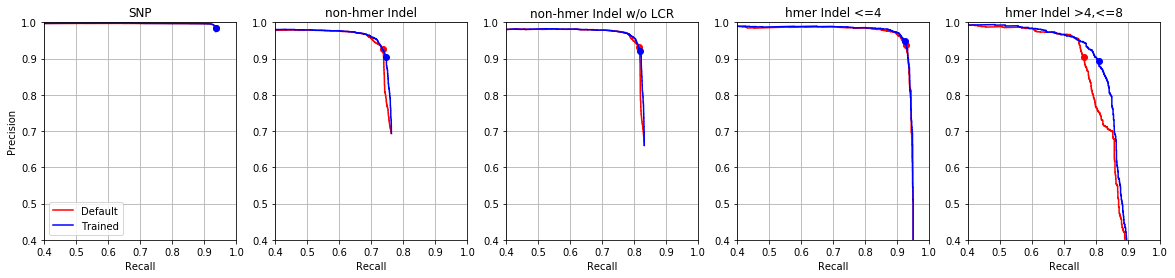

In [8]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab,optRes,perfCurve=getPerformance(data,categories,gt=True)
plotPerformance(perfCurve,optRes,categories)

In [9]:
pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])

Default                                             \
                           pos    neg max Recall opt Recall opt Precision   
SNP                     130318   3144     93.60%     93.50%        98.44%   
non-hmer Indel            8267   2788     76.29%     73.58%        92.66%   
non-hmer Indel w/o LCR    5880   2513     83.15%     81.58%        93.09%   
hmer Indel <=4            2036  23074     95.19%     92.63%        93.74%   
hmer Indel >4,<=8         1323   3373     90.40%     76.27%        90.49%   

                       Trained                                             
                           pos    neg max Recall opt Recall opt Precision  
SNP                     130318   3144     93.60%     93.52%        98.35%  
non-hmer Indel            8267   2788     76.30%     74.72%        90.33%  
non-hmer Indel w/o LCR    5880   2513     83.16%     81.82%        92.16%  
hmer Indel <=4            2036  23074     95.19%     92.39%        94.86%  
hmer Indel >4,<=8         1323   3373     90.40%     80.80%        89.31%

## Performance: cvg>=20, mappability.0

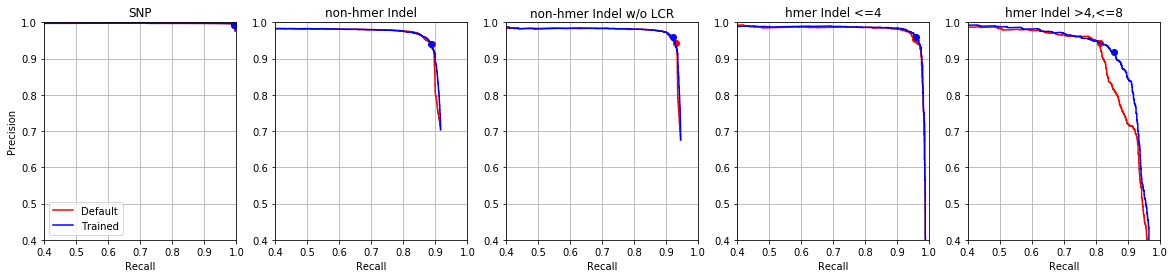

In [10]:
filtData={}
for s in sources:
    d=data[s]
    filtData[s]=d[(d['well_mapped_coverage']>=20) &
                  (d['mappability.0'])
                 ]

categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories)


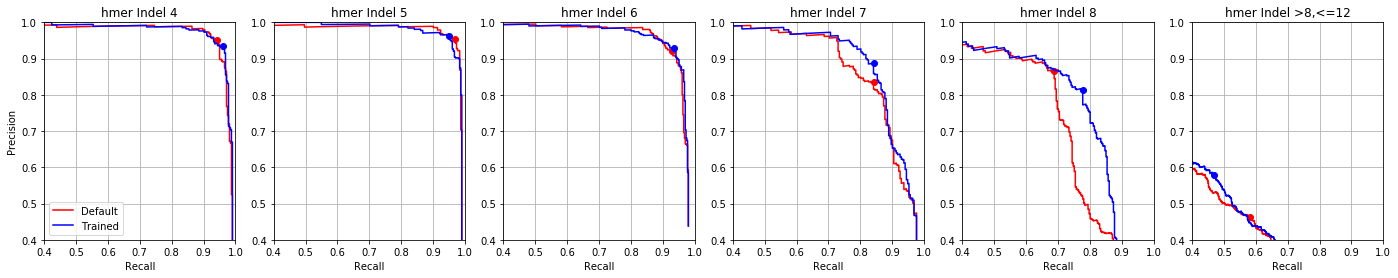

In [11]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=12']
optTab2,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories)


In [12]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])

Default                                             \
                           pos    neg max Recall opt Recall opt Precision   
SNP                     126168   2981     99.57%     99.18%        99.37%   
non-hmer Indel            7096   2735     91.64%     88.90%        94.04%   
non-hmer Indel w/o LCR    5411   2458     94.49%     92.98%        94.39%   
hmer Indel <=4            1968  22883     98.98%     95.63%        95.44%   
hmer Indel >4,<=8         1267   3350     97.32%     81.22%        94.32%   
hmer Indel 4               323   1528     99.07%     94.12%        95.00%   
hmer Indel 5               302    681     99.01%     97.02%        95.44%   
hmer Indel 6               412    519     98.06%     92.96%        92.07%   
hmer Indel 7               252    379     97.62%     84.13%        83.46%   
hmer Indel 8               301   1771     94.35%     68.77%        86.61%   
hmer Indel >8,<=12         695   4169     94.53%     58.27%        46.34%   

                       Trained                                             
                           pos    neg max Recall opt Recall opt Precision  
SNP                     126168   2981     99.57%     99.24%        99.32%  
non-hmer Indel            7096   2735     91.64%     88.64%        93.95%  
non-hmer Indel w/o LCR    5411   2458     94.49%     92.11%        95.90%  
hmer Indel <=4            1968  22883     98.98%     96.04%        95.89%  
hmer Indel >4,<=8         1267   3350     97.32%     85.71%        91.80%  
hmer Indel 4               323   1528     99.07%     95.98%        93.37%  
hmer Indel 5               302    681     99.01%     95.03%        96.31%  
hmer Indel 6               412    519     98.06%     93.69%        93.01%  
hmer Indel 7               252    379     97.62%     84.13%        88.70%  
hmer Indel 8               301   1771     94.35%     77.74%        81.25%  
hmer Indel >8,<=12         695   4169     94.68%     47.05%        57.98%

### Including genotype

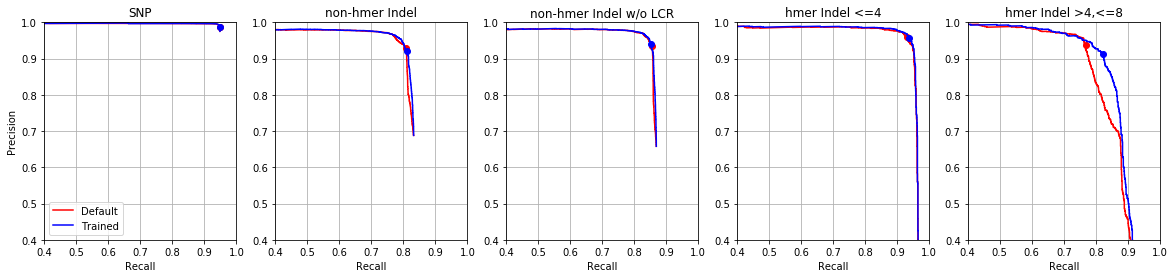

In [13]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab,optRes,perfCurve=getPerformance(filtData,categories,gt=True)
plotPerformance(perfCurve,optRes,categories)

In [14]:
pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])

Default                                             \
                           pos    neg max Recall opt Recall opt Precision   
SNP                     126121   3028     94.84%     94.73%        98.69%   
non-hmer Indel            7137   2694     83.23%     80.79%        92.79%   
non-hmer Indel w/o LCR    5420   2449     86.90%     85.61%        93.34%   
hmer Indel <=4            1966  22885     96.69%     93.03%        95.86%   
hmer Indel >4,<=8         1282   3335     92.20%     76.76%        93.63%   

                       Trained                                             
                           pos    neg max Recall opt Recall opt Precision  
SNP                     126121   3028     94.84%     94.71%        98.82%  
non-hmer Indel            7137   2694     83.24%     81.08%        92.11%  
non-hmer Indel w/o LCR    5420   2449     86.92%     85.28%        94.08%  
hmer Indel <=4            1966  22885     96.69%     93.85%        95.70%  
hmer Indel >4,<=8         1282   3335     92.20%     82.22%        91.18%

### per base

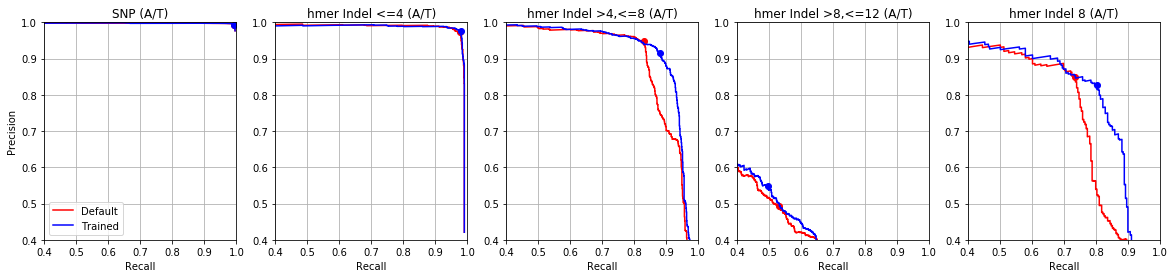

In [15]:
categories=['SNP','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=12','hmer Indel 8']

baseData={}
b =('A','T')
for s in sources:
        d=filtData[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab1,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab1[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab1[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,'A/T')


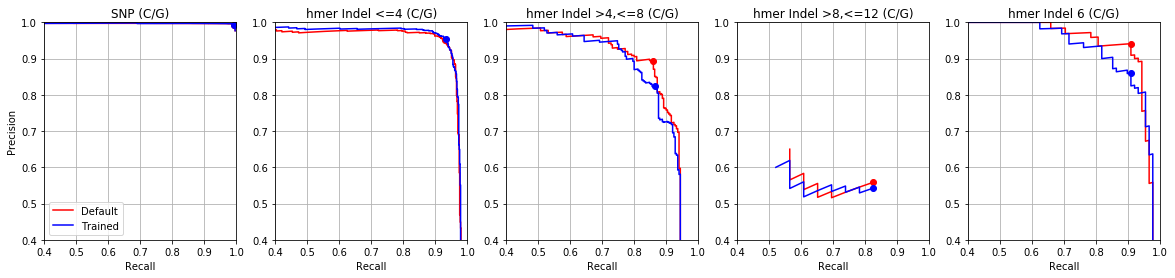

In [16]:
categories=['SNP','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=12','hmer Indel 6']
baseData={}
b =('C','G')
for s in sources:
        d=filtData[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab2,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab2[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab2[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,'C/G')


In [17]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])

Default                                             \
                             pos    neg max Recall opt Recall opt Precision   
SNP (A/T)                  59841   1417     99.56%     99.18%        99.39%   
hmer Indel <=4 (A/T)        1261   1720     99.05%     97.54%        97.31%   
hmer Indel >4,<=8 (A/T)     1017   2772     98.03%     82.99%        94.94%   
hmer Indel >8,<=12 (A/T)     672   4152     94.94%     53.27%        49.38%   
hmer Indel 8 (A/T)           269   1758     96.65%     73.61%        84.98%   
SNP (C/G)                  66327   1562     99.58%     99.19%        99.35%   
hmer Indel <=4 (C/G)         707  21163     98.87%     93.07%        95.09%   
hmer Indel >4,<=8 (C/G)      250    578     94.40%     86.00%        89.21%   
hmer Indel >8,<=12 (C/G)      23     17     82.61%     82.61%        55.88%   
hmer Indel 6 (C/G)            88    206     97.73%     90.91%        94.12%   

                         Trained                                             
                             pos    neg max Recall opt Recall opt Precision  
SNP (A/T)                  59841   1417     99.56%     99.24%        99.33%  
hmer Indel <=4 (A/T)        1261   1720     99.05%     97.86%        97.70%  
hmer Indel >4,<=8 (A/T)     1017   2772     98.03%     88.00%        91.61%  
hmer Indel >8,<=12 (A/T)     672   4152     95.09%     49.70%        54.93%  
hmer Indel 8 (A/T)           269   1758     96.65%     80.30%        82.76%  
SNP (C/G)                  66327   1562     99.58%     99.19%        99.39%  
hmer Indel <=4 (C/G)         707  21163     98.87%     93.35%        95.38%  
hmer Indel >4,<=8 (C/G)      250    578     94.40%     86.40%        82.44%  
hmer Indel >8,<=12 (C/G)      23     17     82.61%     82.61%        54.29%  
hmer Indel 6 (C/G)            88    206     97.73%     90.91%        86.02%